In [1]:
import torch
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from model import AutoEncoder, ConvAEN
from tqdm import tqdm 
import numpy as np
from sklearn.svm import OneClassSVM
from torchsummary import summary
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# save_path = 'model_128.pth'
save_path = 'model_Conv.pth'

In [3]:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Exiting...")
    exit()

CUDA is available. Training on GPU.
Number of GPUs available: 1
GPU name: NVIDIA RTX A5000


In [4]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform_train = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.CenterCrop((128, 128)),
    # transforms.Grayscale(num_output_channels=3),  # 转换为灰度图
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # 将图片转换为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #[-1, 1]
])

transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.CenterCrop((128, 128)),
    # transforms.Resize((128, 128)),  # 调整图片大小
    # transforms.Grayscale(num_output_channels=3),  # 转换为
    transforms.ToTensor(),  # 将图片转换为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #[-1, 1]
])

# 数据集路径
base_path = '/Group16T/raw_data/covid_cxr'

# 加载数据集
train_dataset = datasets.ImageFolder(root=f'{base_path}/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root=f'{base_path}/val', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{base_path}/test', transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=16)

print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}, test_dataset: {len(test_dataset)}")

# 初始化模型
# autoencoder = AutoEncoder().to(device)
autoencoder = ConvAEN().to(device)

# 损失函数和优化器
loss_func = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)


train_dataset: 67863, val_dataset: 8473, test_dataset: 8482


In [5]:
#Load pretrained model
autoencoder.load_state_dict(torch.load(save_path))
print(summary(autoencoder, (3, 128, 128)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
       BatchNorm2d-5           [-1, 16, 64, 64]              32
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
       BatchNorm2d-8           [-1, 32, 32, 32]              64
         MaxPool2d-9           [-1, 32, 16, 16]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 128]       1,048,704
           Linear-12                 [-1, 8192]       1,056,768
  ConvTranspose2d-13           [-1, 16, 32, 32]           4,624
      BatchNorm2d-14           [-1, 16,

## Block below is used to train from scratch

In [8]:
"""
num_epochs = 5

autoencoder.train() #Set model to training mode
for epoch in range(num_epochs): 
    epoch_start_time = datetime.now()  # 记录epoch开始的时间 

    train_loss = 0
    # 使用tqdm包装数据加载器，以显示进度条
    train_loader_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for data in train_loader_pbar:
        img, _ = data  # img is in shape (batch_size, 3, 64, 64) / I don't need label and patient_id in training
        img_flat = img.view(img.size(0), -1)  # Flatten img for the model input
        img_flat = Variable(img_flat).to(device)
        # ===================forward=====================
        output = autoencoder(img_flat)
        output = output.view(img.size(0), 3, 256, 256)  # Reshape output to original shape for loss calculation
        loss = loss_func(output, img.to(device))  # Use original shape img for loss calculation
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================       
    train_loader_pbar.set_description(
                f'Epoch {epoch+1}/{num_epochs} '
                f'[Train] Loss: {train_loss/len(train_loader_pbar):.4f}')
    

#Save model
torch.save(autoencoder.state_dict(), save_path)
"""
   

"\nnum_epochs = 5\n\nautoencoder.train() #Set model to training mode\nfor epoch in range(num_epochs): \n    epoch_start_time = datetime.now()  # 记录epoch开始的时间 \n\n    train_loss = 0\n    # 使用tqdm包装数据加载器，以显示进度条\n    train_loader_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')\n    for data in train_loader_pbar:\n        img, _ = data  # img is in shape (batch_size, 3, 64, 64) / I don't need label and patient_id in training\n        img_flat = img.view(img.size(0), -1)  # Flatten img for the model input\n        img_flat = Variable(img_flat).to(device)\n        # ===================forward=====================\n        output = autoencoder(img_flat)\n        output = output.view(img.size(0), 3, 256, 256)  # Reshape output to original shape for loss calculation\n        loss = loss_func(output, img.to(device))  # Use original shape img for loss calculation\n        # ===================backward====================\n        optimizer.zero_grad()\n        loss.backwar

In [6]:
autoencoder.eval()
val_results = {
    "positive": [],
    "negative": []
}

loss_func = nn.MSELoss(reduction='none')
# 使用tqdm包装数据加载器，以显示进度条
val_loader_pbar = tqdm(val_loader, desc=f'[Val] Single Epoch Validation')
with torch.no_grad():
    for data in val_loader_pbar:
        img, label = data  # img is in shape (batch_size, 3, 64, 64)
        img = img.to(device)
        # img_flat = img.view(img.size(0), -1)  # Flatten img for the model input
        # img_flat = Variable(img_flat).to(device)
        # ===================forward=====================
        output = autoencoder(img)
        output = output.view(img.size(0), 3, 128, 128)  # Reshape output to original shape for loss calculation
        loss = loss_func(output, img.to(device))  # Use original shape img for loss calculation
        loss_per_sample = loss.mean(dim=[1, 2, 3])  # 平均每個樣本的損失，假設是圖像數據

        for i in range(len(label)):
            sample_loss = loss_per_sample[i].item()
            if label[i] == 0:
                val_results["negative"].append(sample_loss)
            else:
                val_results["positive"].append(sample_loss)


[Val] Single Epoch Validation: 100%|██████████| 34/34 [00:22<00:00,  1.48it/s]


In [7]:
print(val_results)
negative_data = np.array(val_results["negative"])
print(negative_data)

{'positive': [0.008679795078933239, 0.0046417610719799995, 0.024037521332502365, 0.0011483285343274474, 0.014995822682976723, 0.0022630176972597837, 0.021044021472334862, 0.004820443689823151, 0.02883322909474373, 0.002476405818015337, 0.0197281651198864, 0.0006438535638153553, 0.0035687244962900877, 0.019831761717796326, 0.0035711433738470078, 0.004214147105813026, 0.024296928197145462, 0.0015999199822545052, 0.013561610132455826, 0.0012602717615664005, 0.011327695101499557, 0.003016833681613207, 0.01781252585351467, 0.0047620562836527824, 0.03373643383383751, 0.003440964501351118, 0.028323059901595116, 0.002898775041103363, 0.023306772112846375, 0.0018558332230895758, 0.021024510264396667, 0.006148468237370253, 0.03555072098970413, 0.004064884968101978, 0.026997506618499756, 0.0032847158145159483, 0.02325616031885147, 0.0032292562536895275, 0.021974537521600723, 0.0030601227190345526, 0.0241992324590683, 0.0033237652387470007, 0.017365675419569016, 0.007334479130804539, 0.03543417155

In [8]:
# #Calculate 95 precentile of negative data
threshold = np.percentile(negative_data, 75)
print(f"Threshold: {threshold}")
def thresholding(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0
    

Threshold: 0.0014060585817787796


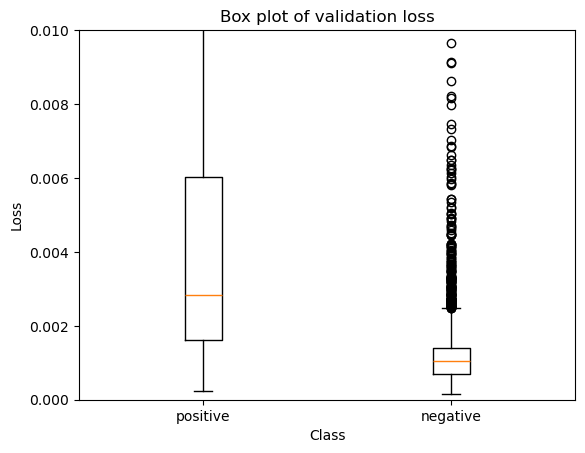

In [9]:
#Draw positive and negative box plot

plt.boxplot([val_results["positive"], val_results["negative"]], labels=["positive", "negative"])

#Range focus on "box" part
plt.ylim(0, 0.01)

plt.title("Box plot of validation loss")
plt.xlabel("Class")
plt.ylabel("Loss")
plt.savefig("output/box_plot.png")
plt.show()


In [10]:
# 初始化列表以存储真实标签和模型预测概率
y_true = []
test_loss = []
y_pred = []


autoencoder.eval()
# 使用tqdm包装数据加载器，以显示进度条
test_loader_pbar = tqdm(test_loader, desc=f'[Test]')
with torch.no_grad():
    for data in test_loader_pbar:
        img, label = data  # img is in shape (batch_size, 3, 64, 64)
        # img_flat = img.view(img.size(0), -1)  # Flatten img for the model input
        # img_flat = Variable(img_flat).to(device)
        img = img.to(device)
        # ===================forward=====================
        output = autoencoder(img)
        output = output.view(img.size(0), 3, 128, 128)  # Reshape output to original shape for loss calculation
        loss = loss_func(output, img.to(device))  # Use original shape img for loss calculation
        loss_per_sample = loss.mean(dim=[1, 2, 3])  # 平均每個樣本的損失，假設是圖像數據
        
        # Save the results
        for i in range(len(label)):
            sample_loss = loss_per_sample[i].item()
            y_true.append(label[i].item())
            test_loss.append(sample_loss)

[Test]:   0%|          | 0/34 [00:00<?, ?it/s]

[Test]: 100%|██████████| 34/34 [00:22<00:00,  1.54it/s]


In [11]:
roc_data = []
max_f1_index = -1
max_f1 = 0
#Calculate ROC

for precentile_num in range(0, 101):
    threshold = np.percentile(negative_data, precentile_num)
    y_pred = [thresholding(x, threshold) for x in test_loss]
    tp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 1])
    tn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 0])
    fp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 0])
    fn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 1])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    #Calculate F1 score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    if f1 > max_f1:
        max_f1 = f1
        max_f1_index = precentile_num
    
    roc_data.append((tpr, fpr))

In [94]:
#  roc_data

AUC: 0.7432588844673831


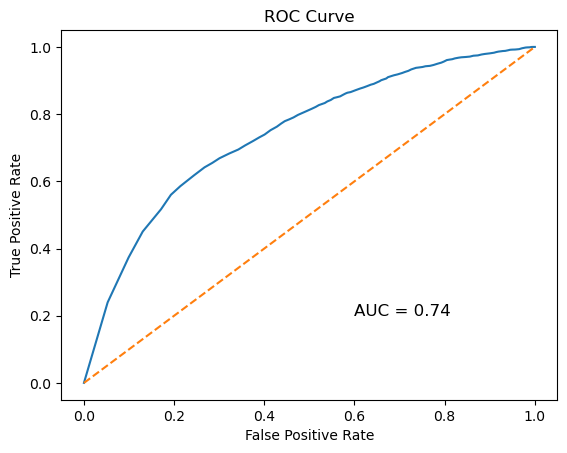

In [12]:
x = [i[1] for i in roc_data]
y = [i[0] for i in roc_data]

# Sort the roc_data based on FPR (x values)
sorted_roc_data = sorted(zip(x, y))

# Recalculate x and y after sorting
x_sorted = [i[0] for i in sorted_roc_data]
y_sorted = [i[1] for i in sorted_roc_data]

# Calculate AUC using the trapezoidal rule
auc = 0
for i in range(1, len(x_sorted)):
    auc += (y_sorted[i] + y_sorted[i-1]) * (x_sorted[i] - x_sorted[i-1]) / 2

print(f"AUC: {auc}")

plt.plot(x, y)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.text(0.6, 0.2, 'AUC = %0.2f' % auc, fontsize=12)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('roc_curve.png')
plt.show()

In [13]:
#calculate the best threshold
threshold = np.percentile(negative_data, max_f1_index)

y_pred = [thresholding(x, threshold) for x in test_loss]
tp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 1])
tn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 0])
fp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 0])
fn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 1])

#Calculate F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"Accuracy: {accuracy}, F1: {f1}, recall: {recall}, precision: {precision}")
print(y_true)
print(y_pred)


Accuracy: 0.6468993161990096, F1: 0.7060555501030523, recall: 0.8481490214572035, precision: 0.6047410894418291
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

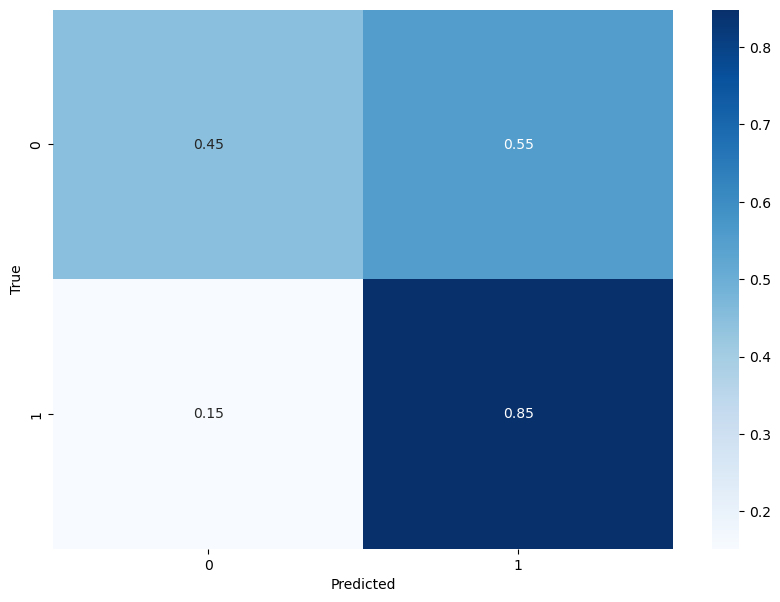

In [14]:
#draw confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def cm_normalized(cm):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

cm = confusion_matrix(y_true, y_pred)
cm_normalized(cm)

In [97]:
# # 将列表转换为numpy数组以便进行向量化计算
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

# # 计算TP, TN, FP, FN
# TP = np.sum((y_pred == 1) & (y_true == 1))
# TN = np.sum((y_pred == 0) & (y_true == 0))
# FP = np.sum((y_pred == 1) & (y_true == 0))
# FN = np.sum((y_pred == 0) & (y_true == 1))


# # 基于TP, TN, FP, FN计算准确率、精确率、召回率（敏感性）、特异性
# accuracy = (TP + TN) / (TP + TN + FP + FN)
# precision = TP / (TP + FP) if (TP + FP) > 0 else 0
# recall = TP / (TP + FN) if (TP + FN) > 0 else 0
# specificity = TN / (TN + FP) if (TN + FP) > 0 else 0


# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"Specificity: {specificity:.4f}")

## 以下先別管他

In [98]:
clf = OneClassSVM(kernel='linear', nu=0.1)
clf.fit(negative_data.reshape(-1, 1))

y_pred = clf.predict(np.array(test_loss).reshape(-1, 1))
y_pred = [1 if x == -1 else 0 for x in y_pred]

tp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 1])
tn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 0])
fp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 0])
fn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 1])

#Calculate F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"Accuracy: {accuracy}, F1: {f1}, recall: {recall}, precision: {precision}")

Accuracy: 0.4530771044564961, F1: 0.0764483376468246, recall: 0.04527234142890828, precision: 0.24552429667519182


In [99]:
import numpy as np
roc_data = []
max_f1_index = -1
max_f1 = 0
#Calculate ROC
for nu in np.arange(0.1, 1.0, 0.1):
    clf = OneClassSVM(kernel='rbf', nu=nu)
    clf.fit(negative_data.reshape(-1, 1))
    y_pred = clf.predict(np.array(test_loss).reshape(-1, 1))
    y_pred = [1 if x == -1 else 0 for x in y_pred]

    tp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 1])
    tn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 0])
    fp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 0])
    fn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 1])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    #Calculate F1 score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    if f1 > max_f1:
        max_f1 = f1
        max_f1_index = precentile_num
    
    roc_data.append((tpr, fpr))
roc_data

[(0.23838717283659513, 0.1362886111766093),
 (0.3452016033954256, 0.21763734968167886),
 (0.44494223060598914, 0.31384107521810894),
 (0.5475123791558595, 0.4395189813723179),
 (0.6486677670360764, 0.555293562838953),
 (0.7373261023343551, 0.6618721999528413),
 (0.8205611883989625, 0.7724593256307475),
 (0.881395897194058, 0.8500353690167414),
 (0.9379863239801933, 0.921244989389295)]

AUC: 0.4841470468191487


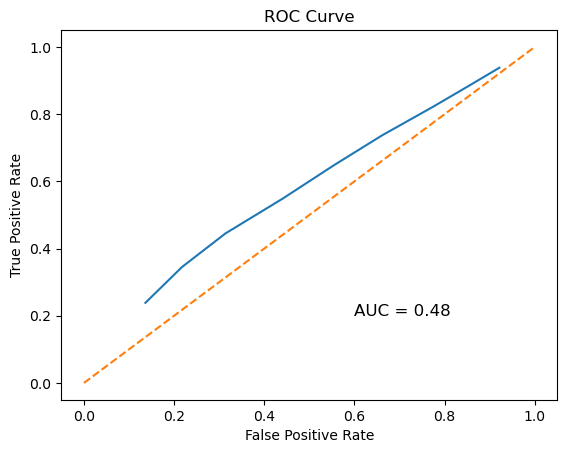

In [100]:
x = [i[1] for i in roc_data]
y = [i[0] for i in roc_data]

# Sort the roc_data based on FPR (x values)
sorted_roc_data = sorted(zip(x, y))

# Recalculate x and y after sorting
x_sorted = [i[0] for i in sorted_roc_data]
y_sorted = [i[1] for i in sorted_roc_data]

# Calculate AUC using the trapezoidal rule
auc = 0
for i in range(1, len(x_sorted)):
    auc += (y_sorted[i] + y_sorted[i-1]) * (x_sorted[i] - x_sorted[i-1]) / 2

print(f"AUC: {auc}")

plt.plot(x, y)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.text(0.6, 0.2, 'AUC = %0.2f' % auc, fontsize=12)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('roc_curve.png')
plt.show()